**IMPORTANT**: Please rename your `B_train1.data` and `B_train1.solution` to `B_test0.data` and `B_test0.solution` respectively.

In [1]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
dataset_name = 'B'
data_path = 'D:\\Data\\AutoML3_input_data_1\\{0}\\{0}_'.format(dataset_name)

## General Information

In [4]:
with open(data_path + 'public.info', 'r') as fh:
    metadata = {line.split(' = ')[0]: line.split(' = ')[1].strip() for line in fh.readlines()}

In [5]:
with open(data_path + 'feat.type', 'r') as fh:
    column_types = [line.strip() for line in fh.readlines()]

In [6]:
metadata

{'feat_num': '25',
 'feat_type': "'Numerical & Categorical & Multi-Value Categorical'",
 'has_categorical': '1',
 'has_missing': '1',
 'is_sparse': '0',
 'label_num': '2',
 'metric': "'auc_metric'",
 'name': "'B'",
 'target_num': '1',
 'target_type': "'Binary'",
 'task': "'binary.classification'",
 'time_budget': '600'}

We see that this dataset contains Multi-Value Categorical features. These are features that can have multiple values per observation. Scikit-learn can not deal with these type of features (I think), so we will have to encode them differently. For now however, we will drop them.

In [7]:
multi_categorical_features = np.asarray([col_type == 'Multi-value' for col_type in column_types])
categorical_features = np.asarray([col_type == 'Categorical' for col_type in column_types])
numerical_features = np.asarray([col_type == 'Numerical' for col_type in column_types])

In [8]:
column_data_types = [float if ctype == 'Numerical' else str for ctype in column_types]
dtype_per_column = dict(enumerate(column_data_types))
numerical_features = np.asarray([ctype == 'Numerical' for ctype in column_types])

In [11]:
X = pd.read_csv(data_path + 'train1.data', sep=' ', header=None, dtype=dtype_per_column)
X_no_multicat = X.loc[:, ~multi_categorical_features]
X_numerical = X.loc[:,numerical_features]
X_categorical = X.loc[:,~numerical_features]

columns_with_nan = X.isnull().any()
nunique_counts = X.apply(pd.Series.nunique)
constant_columns = np.asarray([idx for (idx, nuniques) in nunique_counts.items() if nuniques == 1])

X_train = X_no_multicat.drop(constant_columns, axis='columns')

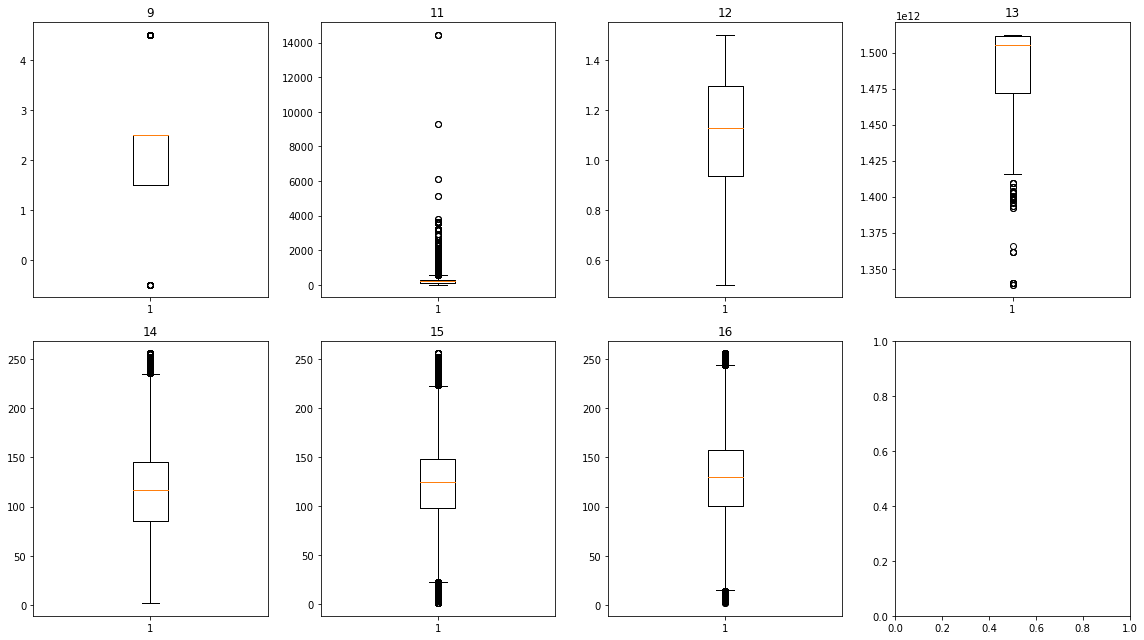

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,9))
for ax, column in zip(axes.flatten(), X_numerical.columns):
    ax.boxplot(X_numerical.loc[:, column].dropna())
    ax.set_title(column)

fig.tight_layout()

In [13]:
y_train = pd.read_csv(data_path + 'train1.solution', header=None)

In [14]:
from collections import Counter
class_counter = Counter(y_train.values.reshape(1,-1)[0])
class_counter, 5243/154812

(Counter({0: 154812, 1: 5243}), 0.03386688370410562)

We see a big class imbalance.

## Baseline Results
We establish three baselines:
 - `DummyClassifier` which always predicts the class prior (and thus should score an AUC of 0.5).
 - `DecisionTreeClassifier` a simple tree model, to verify that there is something to learn from the data.
 - `RandomForestClassifier` a good general algorithm.

In [60]:
dummy = DummyClassifier(strategy='prior')
tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=6)

Next we set up a function which will load a data batch and train a model on it.
Before training, it will:
 - Drop constant columns. Avoid a useless timewaster.
 - Drop the multi-categorical features. We don't encode them (yet), so we can't use them.
 - Impute missing values. For now, we use a median strategy. There are definitely better strategies, especially since we restrict ourselves to trees.

In [72]:
def prepare_train_data(test_no):
    X = pd.read_csv(data_path + 'test{}.data'.format(test_no),
                    sep=' ', header=None, dtype=dtype_per_column)
    X_no_multicat = X.loc[:, ~multi_categorical_features]
    X_numerical = X.loc[:,numerical_features]
    X_categorical = X.loc[:,~numerical_features]

    columns_with_nan = X.isnull().any()
    nunique_counts = X.apply(pd.Series.nunique)
    constant_columns = np.asarray([idx for (idx, nuniques) in nunique_counts.items() if nuniques == 1])

    X_train = X_no_multicat.drop(constant_columns, axis='columns')
    median_imputer = Imputer(strategy='median')
    X_train_imp = median_imputer.fit_transform(X_train)
    
    y_train = pd.read_csv(data_path + 'test{}.solution'.format(test_no), header=None)
    return X_train_imp, y_train.values.ravel()

We set up a function which can then also automatically score the model on a desired test batch.

In [78]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

def prepare_test_data(test_no):
    X_test = pd.read_csv(data_path + 'test{}.data'.format(test_no),
                         sep=' ', header=None, dtype=dtype_per_column)
    X_test = X_test.iloc[:, ~multi_categorical_features].drop(constant_columns, axis='columns')
    X_test_imp = median_imputer.transform(X_test)
    
    y_test = pd.read_csv(data_path + 'test{}.solution'.format(test_no), header=None)    
    y_test = OneHotEncoder().fit_transform(y_test).todense()
    return X_test_imp, y_test

def score_for_data(X, y, model):
    model_predictions = model.predict_proba(X)
    if isinstance(model_predictions, list):
        # For DummyClassifier
        model_predictions = model_predictions[0]
    return roc_auc_score(y, model_predictions)    

Happy evaluation! We want to explore a few things:
 - Do we really need to retrain our model? What happens if we only train the model once?
 - Do we really need all the data? What if we only train on the most recent batch?
 - But.. what if we do use all the data?

In [82]:
df_results = pd.DataFrame(columns=['learner', 'train_partitions', 'test_partition', 'AUC'])

def append_row(df, row_data):
    df.loc[len(df_results.index)] = row_data

def log_score(train_partition, test_partition, model):
    print('scoring {} on {}\r'.format(model.__class__.__name__, test_partition))
    auc = score_for_data(X, y, model)
    append_row(df_results, [model.__class__.__name__, str(train_partition), str(test_partition), auc])

models = [dummy, tree, random_forest]
for train_batch in range(4):
    X, y = prepare_train_data(train_batch)
    for model in models:
        print('fitting {} on train batch {}'.format(model.__class__.__name__, train_batch))
        model.fit(X, y)
    
    for test_batch in range(train_batch+1, 5):
        X_test, y_test = prepare_test_data(test_batch)
        for model in models:
            print('scoring {} on test batch {}'.format(model.__class__.__name__, test_batch))
            auc = score_for_data(X_test, y_test, model)
            append_row(df_results, 
                       [model.__class__.__name__, str(train_batch), str(test_batch), auc])

fitting DummyClassifier on train batch 0
fitting DecisionTreeClassifier on train batch 0
fitting RandomForestClassifier on train batch 0
scoring DummyClassifier on test batch 1
scoring DecisionTreeClassifier on test batch 1
scoring RandomForestClassifier on test batch 1
scoring DummyClassifier on test batch 2
scoring DecisionTreeClassifier on test batch 2
scoring RandomForestClassifier on test batch 2
scoring DummyClassifier on test batch 3
scoring DecisionTreeClassifier on test batch 3
scoring RandomForestClassifier on test batch 3
scoring DummyClassifier on test batch 4
scoring DecisionTreeClassifier on test batch 4
scoring RandomForestClassifier on test batch 4
fitting DummyClassifier on train batch 1
fitting DecisionTreeClassifier on train batch 1
fitting RandomForestClassifier on train batch 1
scoring DummyClassifier on test batch 2
scoring DecisionTreeClassifier on test batch 2
scoring RandomForestClassifier on test batch 2
scoring DummyClassifier on test batch 3
scoring Decision

In [86]:
df_results.sort_values(by=['learner', 'test_partition', 'train_partitions'])

,learner,train_partitions,test_partition,AUC
1,DecisionTreeClassifier,0,1,0.510572
4,DecisionTreeClassifier,0,2,0.504668
13,DecisionTreeClassifier,1,2,0.510235
7,DecisionTreeClassifier,0,3,0.510961
16,DecisionTreeClassifier,1,3,0.509168
22,DecisionTreeClassifier,2,3,0.508787
10,DecisionTreeClassifier,0,4,0.511499
19,DecisionTreeClassifier,1,4,0.508488
25,DecisionTreeClassifier,2,4,0.510067
28,DecisionTreeClassifier,3,4,0.510410


In [91]:
dummy.fit(X, y)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [92]:
dummy.predict_proba(X_test)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])